In [218]:
import dalex as dx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from copy import copy

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

np.random.seed(42)

## Data loading and preprocessing

In [2]:
data = pd.read_csv("health_data.csv")

data = data.apply(lambda col: col.astype("category") if col.dtype == "object" else col)

mapping = {"male": 0, "female": 1, "yes": 1, "no": 0}

# Apply the mapping to the 'SEX' and 'PMI' columns
data["SEX"] = data["SEX"].map(mapping).astype("int32")
data["PMI"] = data["PMI"].map(mapping).astype("int32")

# Summarise categorical variables
data.describe(include=["category"])

,KILLIP,MILOC,SMK,TX
count,40830,40830,40830,40830
unique,4,3,3,3
top,one,Inferior,never,SK
freq,34825,23495,17543,20162


In [3]:
data.DAY30.value_counts()

DAY30
0    37979
1     2851
Name: count, dtype: int64

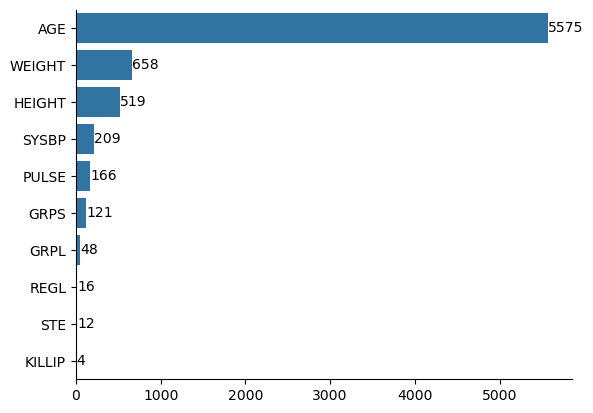

In [363]:
ax = sns.barplot(
    data.apply(lambda x: len(set(x)), axis=0).sort_values(ascending=False)[:10],
    orient="h"
)

ax.bar_label(ax.containers[0], fontsize=10)

sns.despine()

plt.show()

<Axes: xlabel='DAY30', ylabel='AGE'>

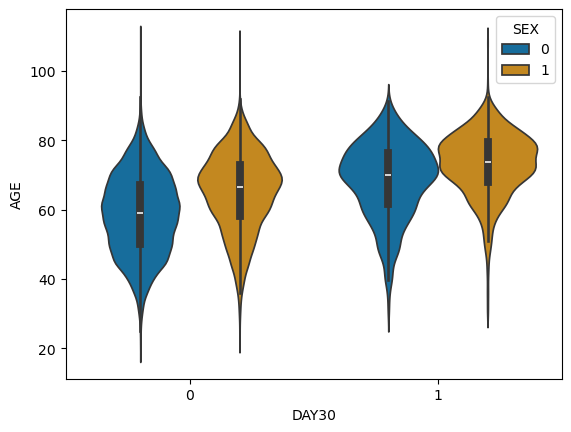

In [71]:
sns.violinplot(
    y="AGE",
    x="DAY30",
    hue="SEX",
    data=data,
    palette="colorblind"
    # kde=True
)

<Axes: xlabel='SEX', ylabel='DAY30'>

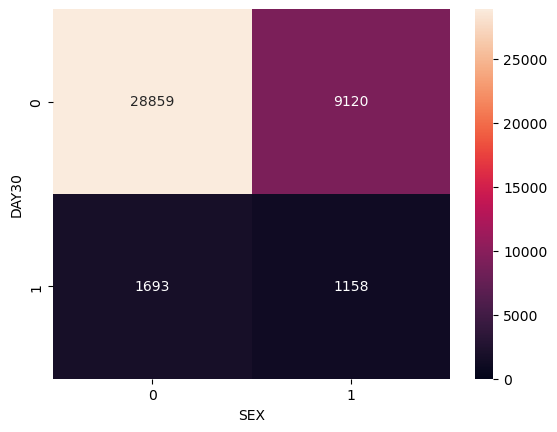

In [352]:
sns.heatmap(
    pd.crosstab(
        data.DAY30,
        data.SEX
    ),
    annot=True,
    fmt="d",
    vmin=0
)

<Axes: xlabel='SMK', ylabel='proportion'>

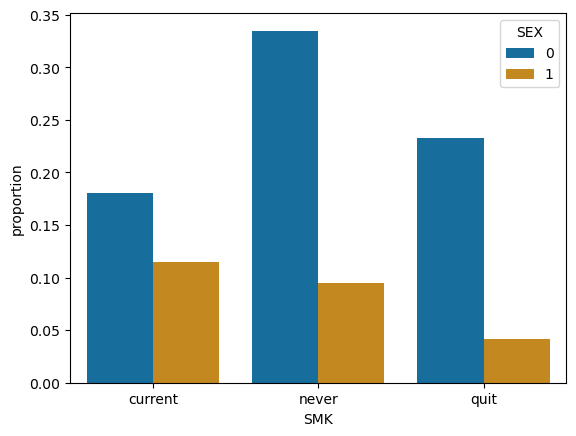

In [326]:
sns.countplot(
    x="SMK",
    hue="SEX",
    data=data,
    stat="proportion",
    palette="colorblind"
)

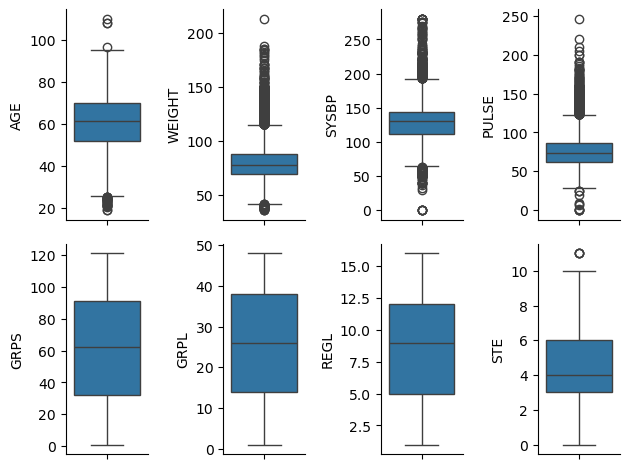

In [371]:
cont_cols = ["AGE", "WEIGHT", "SYSBP", "PULSE", "GRPS", "GRPL", "REGL", "STE"]

fig, axs = plt.subplots(2, 4)

axs = axs.ravel()

for i, col in enumerate(cont_cols):
    sns.boxplot(
        y=col,
        data=data,
        ax=axs[i],
    )
    sns.despine(ax=axs[i])
fig.tight_layout()

In [347]:
X = data.drop(columns="DAY30")
y = data.DAY30

# %% Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()

X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test[cont_cols] = scaler.transform(X_test[cont_cols])

X_train = pd.get_dummies(X_train)

X_test = pd.get_dummies(X_test)

## Utility functions

In [6]:
def clf_report(model):
    # Predict on test data
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual Negative", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Positive"],
    )

    return y_pred, y_prob, cm_df

## Classification

### Dummy classifier

Accuracy score: 0.930
Recall score: 0.000
ROC AUC score: 0.500
PR AUC score: 0.070
F1: 0.000


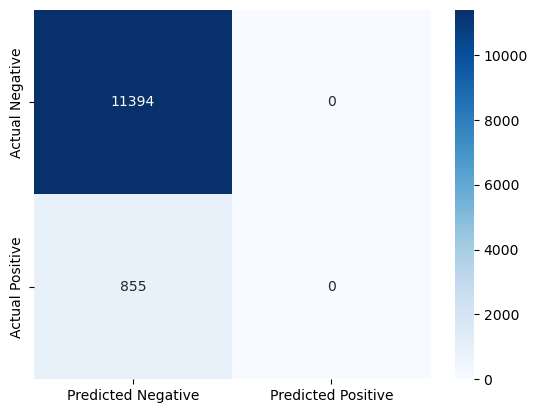

In [222]:
dum = DummyClassifier()

dum.fit(X_train, y_train)

y_pred, y_prob, cm_df = clf_report(dum)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Recall score: {:.3f}".format(recall_score(y_test, y_pred)))
print("ROC AUC score: {:.3f}".format(roc_auc_score(y_test, y_prob)))
print("PR AUC score: {:.3f}".format(average_precision_score(y_test, y_prob)))
print("F1: {:.3f}".format(f1_score(y_test, y_pred)))

### Logistic regression

Accuracy score: 0.754
Recall score: 0.724
ROC AUC score: 0.824
PR AUC score: 0.331
F1: 0.291


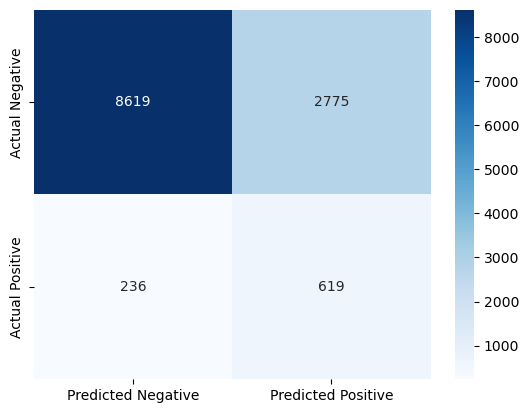

In [348]:
# lr = make_pipeline(
#     LogisticRegression(
#         fit_intercept=False,
#         solver="newton-cg",
#         penalty="l2",
#         max_iter=10000000,
#         verbose=1,
#     )
# )

lr = LogisticRegression(
    fit_intercept=False,
    # solver="newton-cg",
    penalty="l2",
    max_iter=10000000,
    class_weight="balanced"
    # verbose=1,
)

lr.fit(X_train, y_train)

y_pred, y_prob, cm_df = clf_report(lr)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Recall score: {:.3f}".format(recall_score(y_test, y_pred)))
print("ROC AUC score: {:.3f}".format(roc_auc_score(y_test, y_prob)))
print("PR AUC score: {:.3f}".format(average_precision_score(y_test, y_prob)))
print("F1: {:.3f}".format(f1_score(y_test, y_pred)))

In [349]:
exp_lr = dx.Explainer(
    lr,
    data=X_test,
    y=y_test,
    label="glm",
    model_type="classification",
    verbose=True,
)

fobject_lr = exp_lr.model_fairness(protected=X_test.SEX, privileged=0)

fobject_lr.fairness_check(epsilon=0.8)

Preparation of a new explainer is initiated

  -> data              : 12249 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12249 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : glm
  -> predict function  : <function yhat_proba_default at 0x7efcc6322b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00877, mean = 0.358, max = 0.997
  -> model type        : classification will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.995, mean = -0.288, max = 0.971
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 3 metrics: ACC, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '

In [136]:
fobject_lr.plot()

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


### XGBoost

Accuracy score: 0.870
Recall score: 0.503
ROC AUC score: 0.804
PR AUC score: 0.297
F1: 0.350


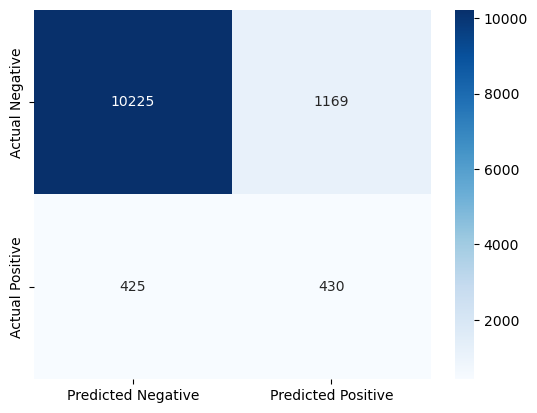

In [350]:
# xgb = make_pipeline(
#     XGBClassifier(
#         random_state=42,
#         reg_lambda=10,
#         max_delta_step=10,
#         scale_pos_weight=15
#     )
# )

xgb = XGBClassifier(
    random_state=42,
    reg_lambda=10,
    max_delta_step=10,
    scale_pos_weight=10,
    device="gpu",
    min_child_weight=10,
    gamma=0.5,
    subsample=0.95,
    eval_metric="auc"
)

xgb.fit(X_train, y_train)

y_pred, y_prob, cm_df = clf_report(xgb)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Recall score: {:.3f}".format(recall_score(y_test, y_pred)))
print("ROC AUC score: {:.3f}".format(roc_auc_score(y_test, y_prob)))
print("PR AUC score: {:.3f}".format(average_precision_score(y_test, y_prob)))
print("F1: {:.3f}".format(f1_score(y_test, y_pred)))

In [124]:
exp_xgb = dx.Explainer(
    xgb,
    data=X_test,
    y=y_test,
    model_type="classification",
    verbose=True,
)

fobject_xgb = exp_xgb.model_fairness(protected=X_test.SEX, privileged=0)

fobject_xgb.fairness_check(epsilon=0.8)

Preparation of a new explainer is initiated

  -> data              : 12249 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12249 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7efcc6322b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000292, mean = 0.201, max = 0.996
  -> model type        : classification will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.989, mean = -0.131, max = 0.998
  -> model_info        : package xgboost

A new explainer has been created!
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by eps

In [125]:
fobject_xgb.plot()

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


[11:31:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


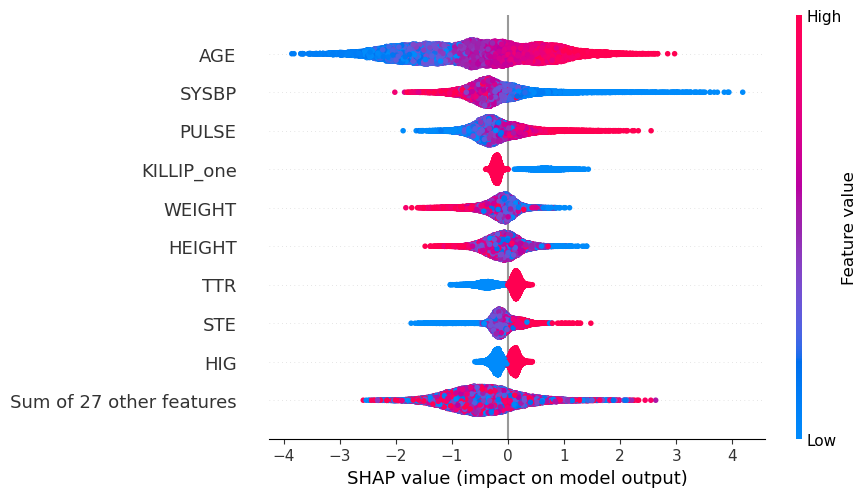

In [134]:
explainer = shap.TreeExplainer(xgb)

shap_values = explainer(X_train)

shap_values.feature_names = list(X_train.columns)

shap.plots.beeswarm(shap_values, max_display=10)

### XGBoost - only age

Recall score: 0.608
ROC AUC score: 0.734
PR AUC score: 0.180
F1: 0.253


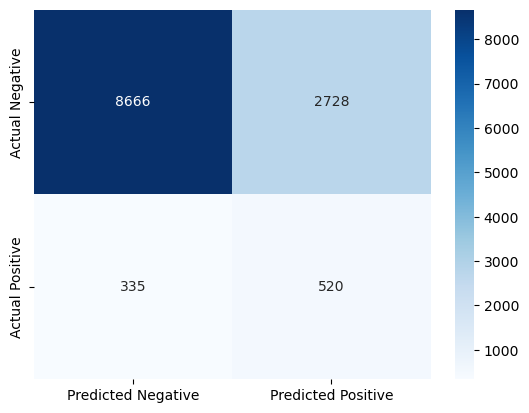

In [232]:
COLS = ["AGE"]

xgb2 = XGBClassifier(
    random_state=42, reg_lambda=10,
    max_delta_step=10, scale_pos_weight=10,
    device="gpu", min_child_weight=10,
    gamma=0.5,
    subsample=0.95
)

xgb2.fit(X_train[COLS], y_train)

X_test_new = X_test[COLS]

y_prob = xgb2.predict_proba(X_test_new)[:, 1]
y_pred = xgb2.predict(X_test_new)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)

# y_pred, y_prob, cm_df = clf_report(xgb2)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

print("Recall score: {:.3f}".format(recall_score(y_test, y_pred)))
print("ROC AUC score: {:.3f}".format(roc_auc_score(y_test, y_prob)))
print("PR AUC score: {:.3f}".format(average_precision_score(y_test, y_prob)))
print("F1: {:.3f}".format(f1_score(y_test, y_pred)))

In [233]:
exp_xgb2 = dx.Explainer(
    xgb2,
    data=X_test[COLS],
    y=y_test,
    label="glm",
    model_type="classification",
    verbose=True,
)

fobject_xgb2 = exp_xgb2.model_fairness(protected=X_test.SEX, privileged=0)

fobject_xgb2.fairness_check(epsilon=0.8)

Preparation of a new explainer is initiated

  -> data              : 12249 rows 1 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12249 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : glm
  -> predict function  : <function yhat_proba_default at 0x7efcc6322b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00807, mean = 0.354, max = 0.851
  -> model type        : classification will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.851, mean = -0.284, max = 0.992
  -> model_info        : package xgboost

A new explainer has been created!
Bias detected in 5 metrics: TPR, ACC, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0'. Paramet

In [56]:
fobject_xgb2.plot()

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


### The cardiologist's recommendations

Accuracy score: 0.831
Recall score: 0.568
ROC AUC score: 0.801
PR AUC score: 0.297
F1: 0.320


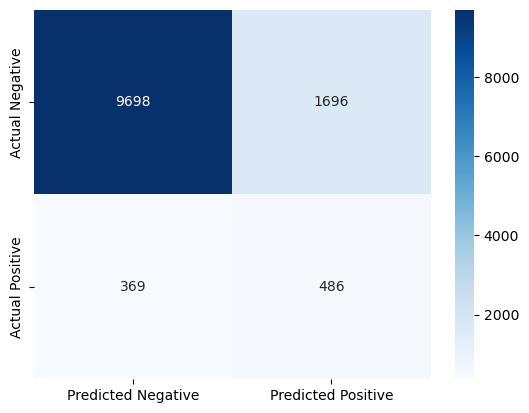

In [319]:
COLS = ['KILLIP_one', 'KILLIP_three', 'KILLIP_two', "HIG", "HYP", "HRT", "TTR", "AGE", "PULSE", "SYSBP", "ANT"]

xgb3 = XGBClassifier(
    random_state=42,
    device="gpu",
    reg_lambda=10,
    max_delta_step=10,
    scale_pos_weight=10,
    min_child_weight=10,
    gamma=0.5,
    subsample=0.95,
)

xgb3.fit(X_train[COLS], y_train)

X_test_new = X_test[COLS]

y_prob = xgb3.predict_proba(X_test_new)[:, 1]
y_pred = xgb3.predict(X_test_new)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

print("Accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Recall score: {:.3f}".format(recall_score(y_test, y_pred)))
print("ROC AUC score: {:.3f}".format(roc_auc_score(y_test, y_prob)))
print("PR AUC score: {:.3f}".format(average_precision_score(y_test, y_prob)))
print("F1: {:.3f}".format(f1_score(y_test, y_pred)))

## Between-sex analysis

In [325]:
for sex in X_test.SEX.unique():
    sub_X_test = X_test.query("SEX == @sex")

    sub_y_test = y_test.loc[sub_X_test.index]

    print(f"Sex == {sex} ({sub_X_test.shape[0]} values; {100*sub_y_test.mean():.2f}% of positive events)")

    y_prob = xgb.predict_proba(sub_X_test)[:, 1]
    y_pred = xgb.predict(sub_X_test)

    print("Accuracy score: {:.3f}".format(accuracy_score(sub_y_test, y_pred)))
    print("ROC AUC score: {:.3f}".format(roc_auc_score(sub_y_test, y_prob)))
    print("PR AUC score: {:.3f}".format(average_precision_score(sub_y_test, y_prob)))
    print("F1: {:.3f}".format(f1_score(sub_y_test, y_pred)))
    print()

Sex == 0 (9175 values; 5.33% of positive events)
Accuracy score: 0.901
ROC AUC score: 0.806
PR AUC score: 0.286
F1: 0.340

Sex == 1 (3074 values; 11.91% of positive events)
Accuracy score: 0.777
ROC AUC score: 0.755
PR AUC score: 0.315
F1: 0.364



## Bias mitigation

### Resampling

In [165]:
clf_u = copy(xgb)
clf_p = copy(xgb)

y_prob_train = xgb.predict_proba(X_train)[:, 1]

indices_uniform = dx.fairness.resample(X_train.SEX, y_train, verbose=True)
indices_preferential = dx.fairness.resample(
    X_train.SEX,
    y_train,
    type="preferential",  # different type
    probs=y_prob_train,  # requires probabilities
    verbose=False,
)

clf_u.fit(X_train.iloc[indices_uniform, :], y_train.iloc[indices_uniform])
clf_p.fit(X_train.iloc[indices_preferential, :], y_train.iloc[indices_preferential])

protected Series will be converted to np.ndarray
protected array is not string type, converting to string 
Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=10,
              max_depth=None, max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [167]:
exp_u = dx.Explainer(clf_u, X_test, y_test, verbose=False)
exp_u.model_performance().result

,recall,precision,f1,accuracy,auc
XGBClassifier,0.418713,0.263042,0.323105,0.877541,0.789444


In [168]:
exp_p = dx.Explainer(clf_p, X_test, y_test, verbose=False)
exp_p.model_performance().result

,recall,precision,f1,accuracy,auc
XGBClassifier,0.418713,0.257554,0.318931,0.875173,0.760896


### Re-weighting

#### XGBoost

In [192]:
weights = dx.fairness.reweight(X_train.SEX, y_train, verbose=True)

print(set(weights))

xgb_weighted = XGBClassifier(
    random_state=42,
    device="gpu",
    reg_lambda=100,
    max_delta_step=100,
    scale_pos_weight=5,
    # min_child_weight=10,
    # gamma=0.5,
    subsample=0.95,
    eval_metric="auc",
)

xgb_weighted.fit(X_train, y_train, sample_weight=weights)

exp_weighted = dx.Explainer(xgb_weighted, X_test, y_test, verbose=False)
exp_weighted.model_performance().result

Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
protected Series will be converted to np.ndarray
protected array is not string type, converting to string 
{0.9856790214905231, 1.045055692369257, 1.2399477570362765, 0.6352309350105089}


,recall,precision,f1,accuracy,auc
XGBClassifier,0.397661,0.315399,0.351785,0.897706,0.805169


In [193]:
exp_xgb_weighted = dx.Explainer(
    xgb_weighted,
    data=X_test,
    y=y_test,
    model_type="classification",
    verbose=True,
)

fobject_xgb_weighted = exp_xgb_weighted.model_fairness(
    protected=X_test.SEX,
    privileged=0
)

fobject_xgb_weighted.fairness_check(epsilon=0.8)

Preparation of a new explainer is initiated

  -> data              : 12249 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12249 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7efcc6322b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00234, mean = 0.17, max = 0.981
  -> model type        : classification will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.957, mean = -0.1, max = 0.994
  -> model_info        : package xgboost

A new explainer has been created!
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon

In [194]:
fobject_xgb_weighted.plot()

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


In [197]:
fobject_xgb_weighted.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
0,0.425,0.942,0.293,0.967,0.575,0.058,0.707,0.033,0.915,0.077
1,0.361,0.912,0.358,0.913,0.639,0.088,0.642,0.087,0.847,0.120


Sex == 0 (9175 values; 5.33% of positive events)
Accuracy score: 0.915
ROC AUC score: 0.815
PR AUC score: 0.307
F1: 0.347

Sex == 1 (3074 values; 11.91% of positive events)
Accuracy score: 0.847
ROC AUC score: 0.765
PR AUC score: 0.317
F1: 0.359



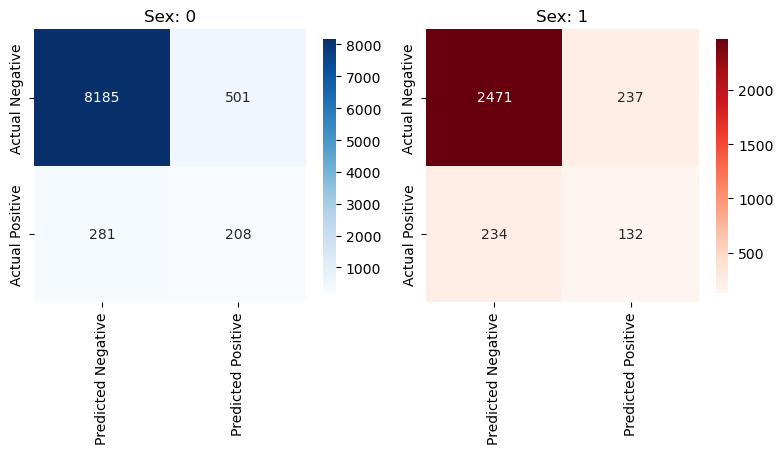

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

palettes = ("Blues", "Reds")

for i, sex in enumerate(X_test.SEX.unique()):
    sub_X_test = X_test.query("SEX == @sex")

    sub_y_test = y_test.loc[sub_X_test.index]

    print(
        f"Sex == {sex} ({sub_X_test.shape[0]} values; {100*sub_y_test.mean():.2f}% of positive events)"
    )

    y_prob = xgb_weighted.predict_proba(sub_X_test)[:, 1]
    y_pred = xgb_weighted.predict(sub_X_test)

    cm = confusion_matrix(sub_y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual Negative", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Positive"],
    )

    sns.heatmap(
        cm_df,
        annot=True,
        cmap=palettes[i],
        fmt="d",
        square=True,
        ax=axs[i],
        cbar_kws={"shrink": .33}
    )

    axs[i].set_title(f"Sex: {sex}")

    print("Accuracy score: {:.3f}".format(accuracy_score(sub_y_test, y_pred)))
    print("ROC AUC score: {:.3f}".format(roc_auc_score(sub_y_test, y_prob)))
    print("PR AUC score: {:.3f}".format(average_precision_score(sub_y_test, y_prob)))
    print("F1: {:.3f}".format(f1_score(sub_y_test, y_pred)))
    print()

fig.tight_layout()

[13:10:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


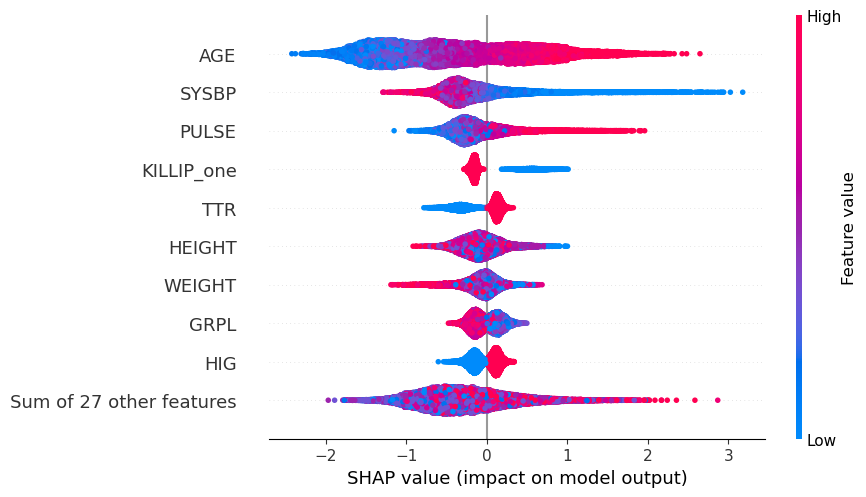

In [322]:
explainer = shap.TreeExplainer(xgb_weighted)

shap_values = explainer(X_train)

shap_values.feature_names = list(X_train.columns)

shap.plots.beeswarm(shap_values, max_display=10)

<Axes: >

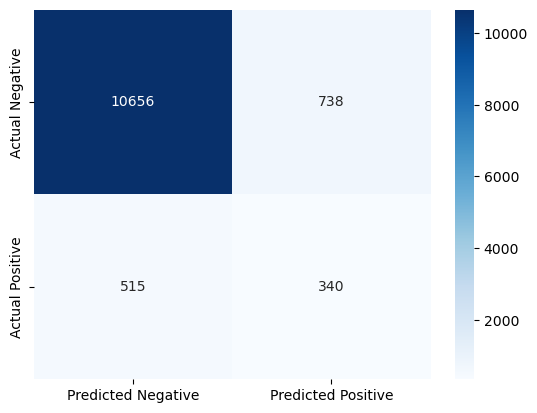

In [199]:
y_pred, y_prob, cm_df = clf_report(xgb_weighted)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

#### Logistic Regression

In [237]:
lr_weighted = LogisticRegression(
    fit_intercept=False,
    # solver="newton-cg",
    penalty="l2",
    max_iter=10000000,
    class_weight="balanced"
    # verbose=1,
)

lr_weighted.fit(X_train, y_train, sample_weight=weights)

exp_lr_weighted = dx.Explainer(lr_weighted, X_test, y_test, verbose=False)
exp_lr_weighted.model_performance().result

,recall,precision,f1,accuracy,auc
LogisticRegression,0.712281,0.178174,0.285046,0.750592,0.810327


In [239]:
exp_lr_weighted = dx.Explainer(
    lr_weighted,
    data=X_test,
    y=y_test,
    model_type="classification",
    verbose=True,
)

fobject_lr_weighted = exp_lr_weighted.model_fairness(
    protected=X_test.SEX,
    privileged=0
)

fobject_lr_weighted.fairness_check(epsilon=0.8)

Preparation of a new explainer is initiated

  -> data              : 12249 rows 36 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12249 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7efcc6322b80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00869, mean = 0.364, max = 0.998
  -> model type        : classification will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.997, mean = -0.294, max = 0.968
  -> model_info        : package sklearn

A new explainer has been created!
Bias detected in 1 metric: PPV

Conclusion: your model cannot be called fair because 1 criterion exceeded acceptable l

<Axes: >

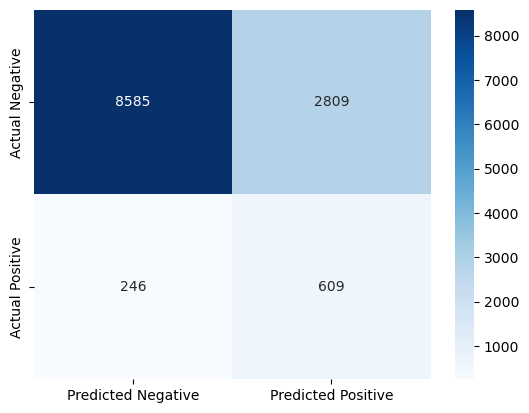

In [240]:
y_pred, y_prob, cm_df = clf_report(lr_weighted)

sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d")

Sex == 0 (9175 values; 5.33% of positive events)
Accuracy score: 0.760
ROC AUC score: 0.825
PR AUC score: 0.308
F1: 0.245

Sex == 1 (3074 values; 11.91% of positive events)
Accuracy score: 0.722
ROC AUC score: 0.777
PR AUC score: 0.362
F1: 0.371



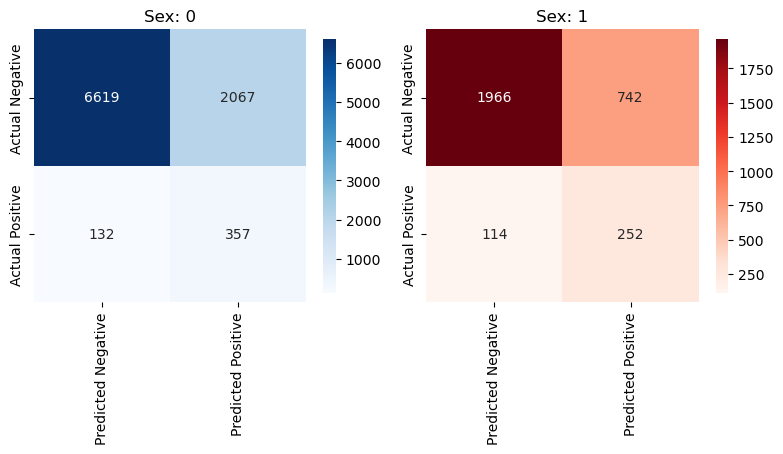

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

palettes = ("Blues", "Reds")

for i, sex in enumerate(X_test.SEX.unique()):
    sub_X_test = X_test.query("SEX == @sex")

    sub_y_test = y_test.loc[sub_X_test.index]

    print(
        f"Sex == {sex} ({sub_X_test.shape[0]} values; {100*sub_y_test.mean():.2f}% of positive events)"
    )

    y_prob = lr_weighted.predict_proba(sub_X_test)[:, 1]
    y_pred = lr_weighted.predict(sub_X_test)

    cm = confusion_matrix(sub_y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual Negative", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Positive"],
    )

    sns.heatmap(
        cm_df,
        annot=True,
        cmap=palettes[i],
        fmt="d",
        square=True,
        ax=axs[i],
        cbar_kws={"shrink": 0.33},
    )

    axs[i].set_title(f"Sex: {sex}")

    print("Accuracy score: {:.3f}".format(accuracy_score(sub_y_test, y_pred)))
    print("ROC AUC score: {:.3f}".format(roc_auc_score(sub_y_test, y_prob)))
    print("PR AUC score: {:.3f}".format(average_precision_score(sub_y_test, y_prob)))
    print("F1: {:.3f}".format(f1_score(sub_y_test, y_pred)))
    print()

fig.tight_layout()

### ROC pivot

In [230]:
exp_roc = copy(exp_xgb)

# roc pivot
exp_roc = dx.fairness.roc_pivot(
    exp_roc, protected=X_test.SEX, privileged=0, theta=0.02, verbose=True
)

exp_roc.model_performance().result

protected Series will be converted to np.ndarray
protected array is not string type, converting to string 


,recall,precision,f1,accuracy,auc
XGBClassifier,0.502924,0.273363,0.354201,0.87199,0.804053


## Summary

In [285]:
fobject1 = exp_lr.model_fairness(protected=X_test.SEX, privileged=0, label="lr")
fobject2 = exp_xgb.model_fairness(protected=X_test.SEX, privileged=0, label="xgb")
fobject3 = exp_xgb2.model_fairness(protected=X_test.SEX, privileged=0, label="xgb_just_age")
fobject4 = exp_xgb_weighted.model_fairness(protected=X_test.SEX, privileged=0, label="xgb_weighted")
fobject5 = exp_roc.model_fairness(protected=X_test.SEX, privileged=0, label="xgb_roc")
fobject6 = exp_lr_weighted.model_fairness(protected=X_test.SEX, privileged=0, label="lr_weighted")

# plotting
fobject1.plot([fobject2, fobject5, fobject4, fobject3, fobject6])

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack

In [282]:
fig = fobject1.plot(
    objects=[
        fobject2,
        fobject5,
        fobject4,
        fobject3,
        fobject6,
    ],  # for better visibility only one additional model
    type="ceteris_paribus_cutoff",
    subgroup="1",
    show=False
)  # necessary argument

fig.update_layout(
    autosize=False,
    width=800,
    height=1200,
)